In [1]:
import numpy as np 
import pandas as pd 
import os
import json
from pandas.io.json import json_normalize
import ast
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
%matplotlib notebook
from scipy.stats import skew, boxcox
import plotly.offline as py
py.init_notebook_mode(connected=True)
import re
import yaml
import json
from collections import Counter
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import eli5
import time
from datetime import datetime
import warnings  
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Overview

The end goal of this notebook is try to predict critic scores

# Loading in the data

In [2]:
train = pd.read_csv('tmdb.zip')
test = pd.read_csv('test.csv')
rotten = pd.read_json('rotten-tomatoes.json.gz', lines = True)

train = train.merge(rotten, on = ['imdb_id'])
test = test.merge(rotten, on = ['imdb_id'])

In [3]:
train = train.drop(['rotten_tomatoes_id'], axis = 1)
test = test.drop(['rotten_tomatoes_id'], axis = 1)

Some Budget and Revenue found online

In [4]:
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1542,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture

test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

We want to convert the date format from mm/dd/yy to yyyy-mm-dd

In [5]:
def date_features(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day
    df['release_quarter'] = df['release_date'].dt.quarter
    df.drop(columns=['release_date'], inplace=True)
    return df

train = date_features(train)
test = date_features(test)

For years that are > 19, they would have been converted to 20XX
which is the wrong year, so we subtracted by 100

In [6]:
train['release_year'] = np.where(train['release_year'] > 2019, train['release_year']-100, train['release_year'])
test['release_year'] = np.where(test['release_year'] > 2019, test['release_year']-100, test['release_year'])

In [7]:
# fill NA with mode

fillna_column = {'release_year':'mode', 'release_month':'mode', 'release_day':'mode'}

for k,v in fillna_column.items():
    if v == 'mode':
        fill = train[k].mode()[0]
    else:
         fill = v
    print(k, ': ', fill)
    train[k].fillna(value = fill, inplace = True)
    test[k].fillna(value = fill, inplace = True)

release_year :  2013
release_month :  9
release_day :  1


In [8]:
def year_month_together(df):
    year = df["release_year"].astype(int).copy().astype(str)
    month = df['release_month'].astype(int).copy().astype(str)
    day = df['release_day'].astype(int).copy().astype(str) 
    df["release_date"] =  month.str.cat(day.str.cat(year,sep="/"), sep ="/") 
    df['release_date'] = pd.to_datetime(df['release_date'],format="%m/%d/%Y")
    df['release_dow'] = df['release_date'].dt.dayofweek
    return df 

train = year_month_together(train)
test = year_month_together(test)

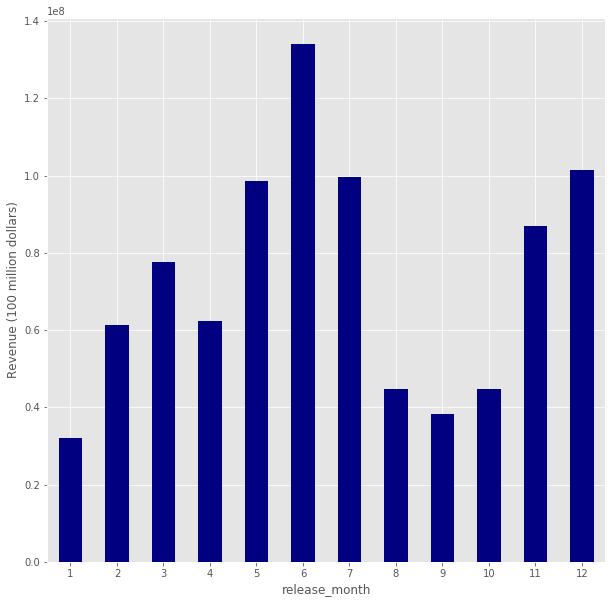

In [9]:
# Average revenue by month

fig = plt.figure(figsize=(10,10))

train.groupby('release_month').agg('mean')['revenue'].plot(kind='bar',color='navy',rot=0)
plt.ylabel('Revenue (100 million dollars)')

plt.savefig('average_revenue_by_month.png')

Text(0.5, 1.0, 'Mean Popularity Over Years')

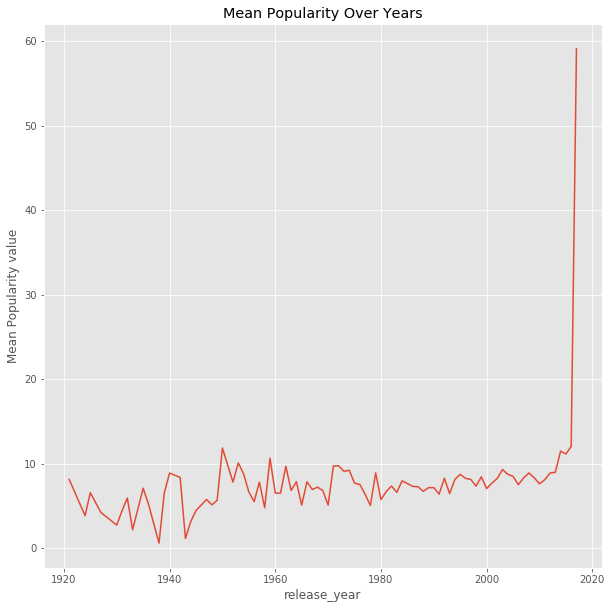

In [10]:
release_year_mean_data=train.groupby(['release_year'])['budget','popularity','revenue'].mean()
release_year_mean_data.head()

fig = plt.figure(figsize=(10, 10))
release_year_mean_data['popularity'].plot(kind='line')
plt.ylabel('Mean Popularity value')
plt.title('Mean Popularity Over Years')
# plt.savefig('mean_pop_over_years.png')

Text(0.5, 1.0, 'Mean Critic Percent Over Years')

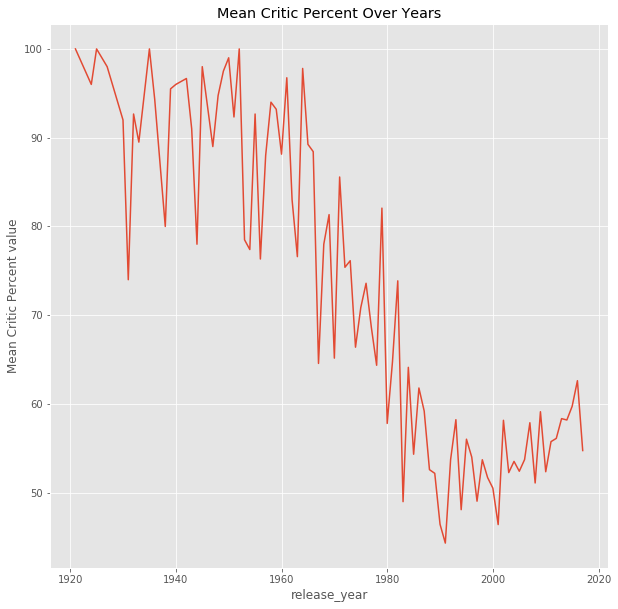

In [11]:
release_year_percent_data=train.groupby(['release_year'])['critic_percent','audience_percent'].mean()
release_year_percent_data.head()

fig = plt.figure(figsize=(10, 10))
release_year_percent_data['critic_percent'].plot(kind='line')
plt.ylabel('Mean Critic Percent value')
plt.title('Mean Critic Percent Over Years')
# plt.savefig('mean_critc_rating_over_years.png')

Text(0.5, 1.0, 'Mean Critic Percent Over Years')

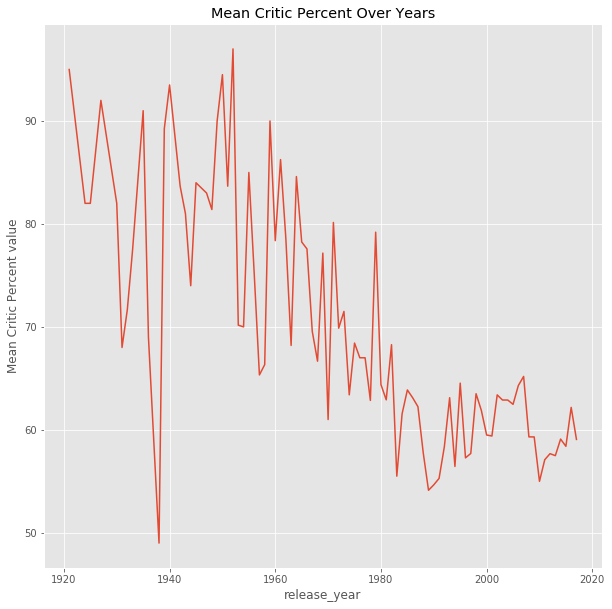

In [12]:
fig = plt.figure(figsize=(10, 10))
release_year_percent_data['audience_percent'].plot(kind='line')
plt.ylabel('Mean Critic Percent value')
plt.title('Mean Critic Percent Over Years')
# plt.savefig('mean_critc_rating_over_years.png')

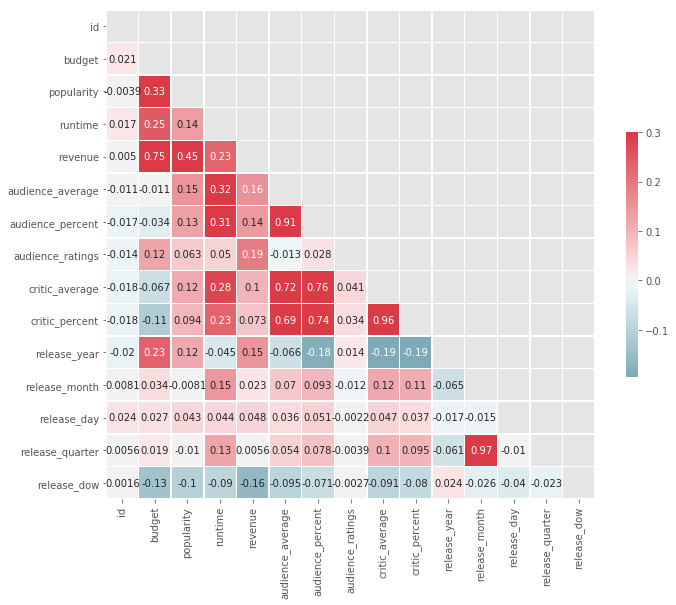

In [13]:
# Creating correlation matrix 

corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# plt.savefig('corr.png')

### There is a lot of text data that can be used to classify our rows, so we will change them into one hot encoding

In [14]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

In [15]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)


test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)


train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

In [16]:
#one hot encoding the genres

list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)


train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)
    
    
train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

In [17]:
#one hot encoding the companies

list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)


train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)

    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

    
train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

In [18]:
#one hot encoding the countries

list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)


train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)

    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

    
train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

In [19]:
#one hot encoding the languages

list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)


train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

    
train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

In [20]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)


train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

    
train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

In [21]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)


train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
train['all_cast'] = train['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(30)]
for g in top_cast_names:
    train['cast_name_' + g] = train['all_cast'].apply(lambda x: 1 if g in x else 0)
        
        
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
test['all_cast'] = test['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_cast_names:
    test['cast_name_' + g] = test['all_cast'].apply(lambda x: 1 if g in x else 0)

In [22]:
# Consider other factors like gender and characters 

list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)


train['genders_0'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
    
test['genders_0'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

    
train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

In [23]:
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
train['all_crew'] = train['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(30)]
for g in top_crew_names:
    train['crew_name_' + g] = train['all_crew'].apply(lambda x: 1 if g in x else 0)
    
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
test['all_crew'] = test['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_crew_names:
    test['crew_name_' + g] = test['all_crew'].apply(lambda x: 1 if g in x else 0)

In [24]:
# Consider other factors like crew jobs, gender, and department 

list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)


train['genders_0'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['crew_character_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
    
test['genders_0'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['crew_character_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

    
train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

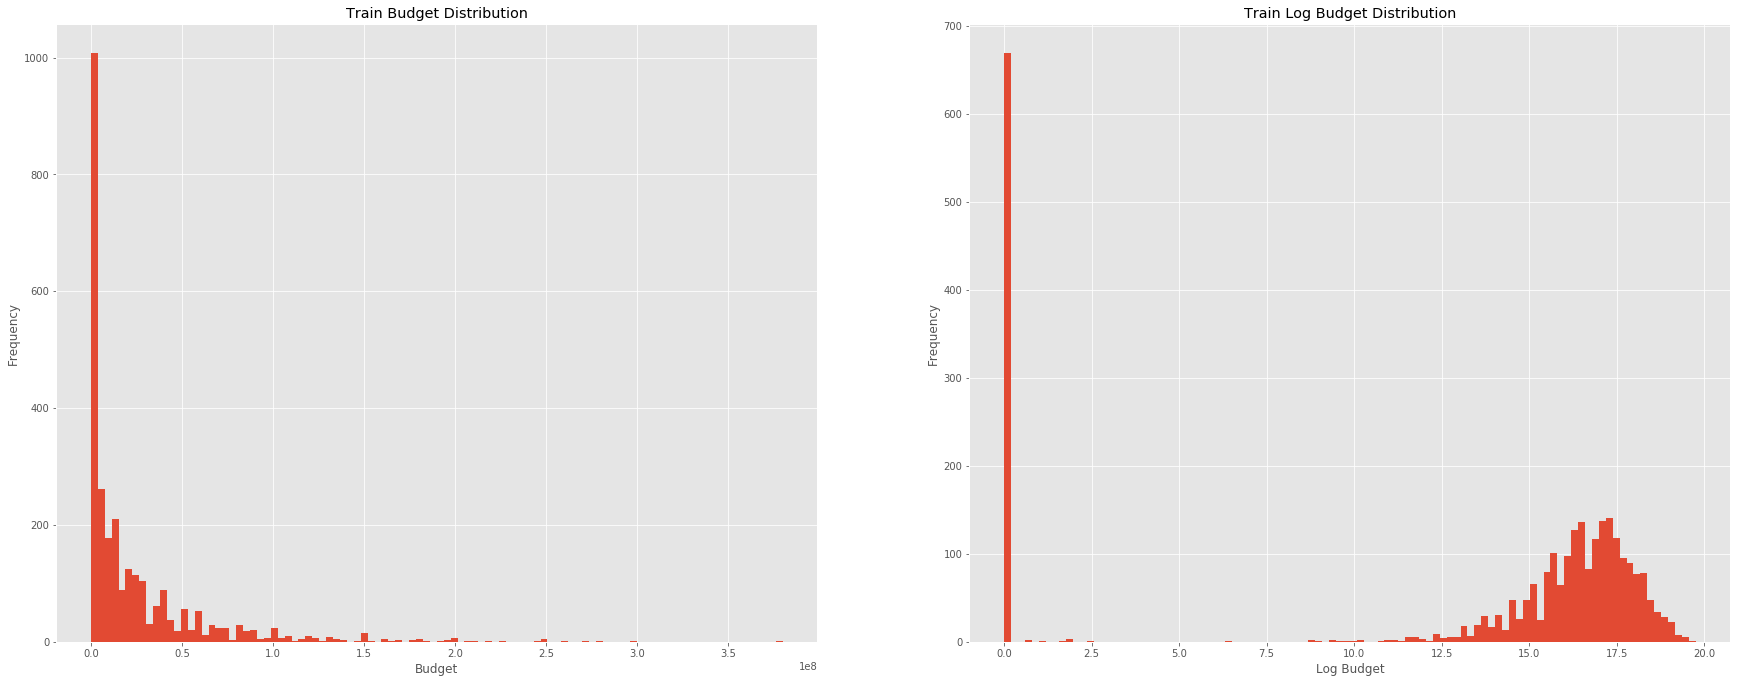

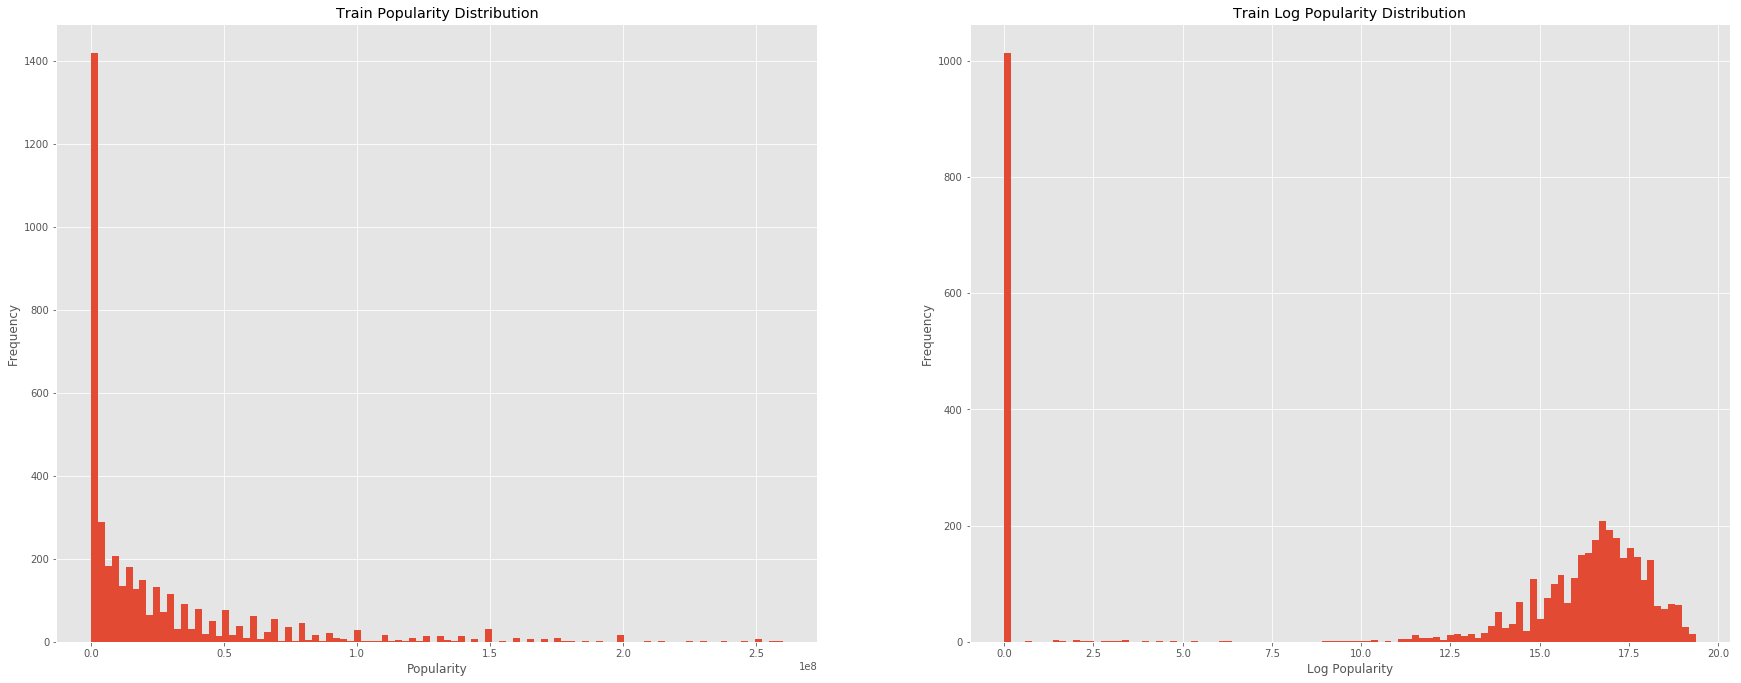

In [25]:
fig = plt.figure(figsize=(30, 25))

plt.subplot(221)
train['budget'].plot(kind='hist',bins=100)
plt.title('Train Budget Distribution')
plt.xlabel('Budget')

plt.subplot(222)
np.log1p(train['budget']).plot(kind='hist',bins=100)
plt.title('Train Log Budget Distribution')
plt.xlabel('Log Budget')

plt.show()

fig = plt.figure(figsize=(30, 25))

plt.subplot(223)
test['budget'].plot(kind='hist',bins=100)
plt.title('Train Popularity Distribution')
plt.xlabel('Popularity')

plt.subplot(224)
np.log1p(test['budget']).plot(kind='hist',bins=100)
plt.title('Train Log Popularity Distribution')
plt.xlabel('Log Popularity')
plt.show()

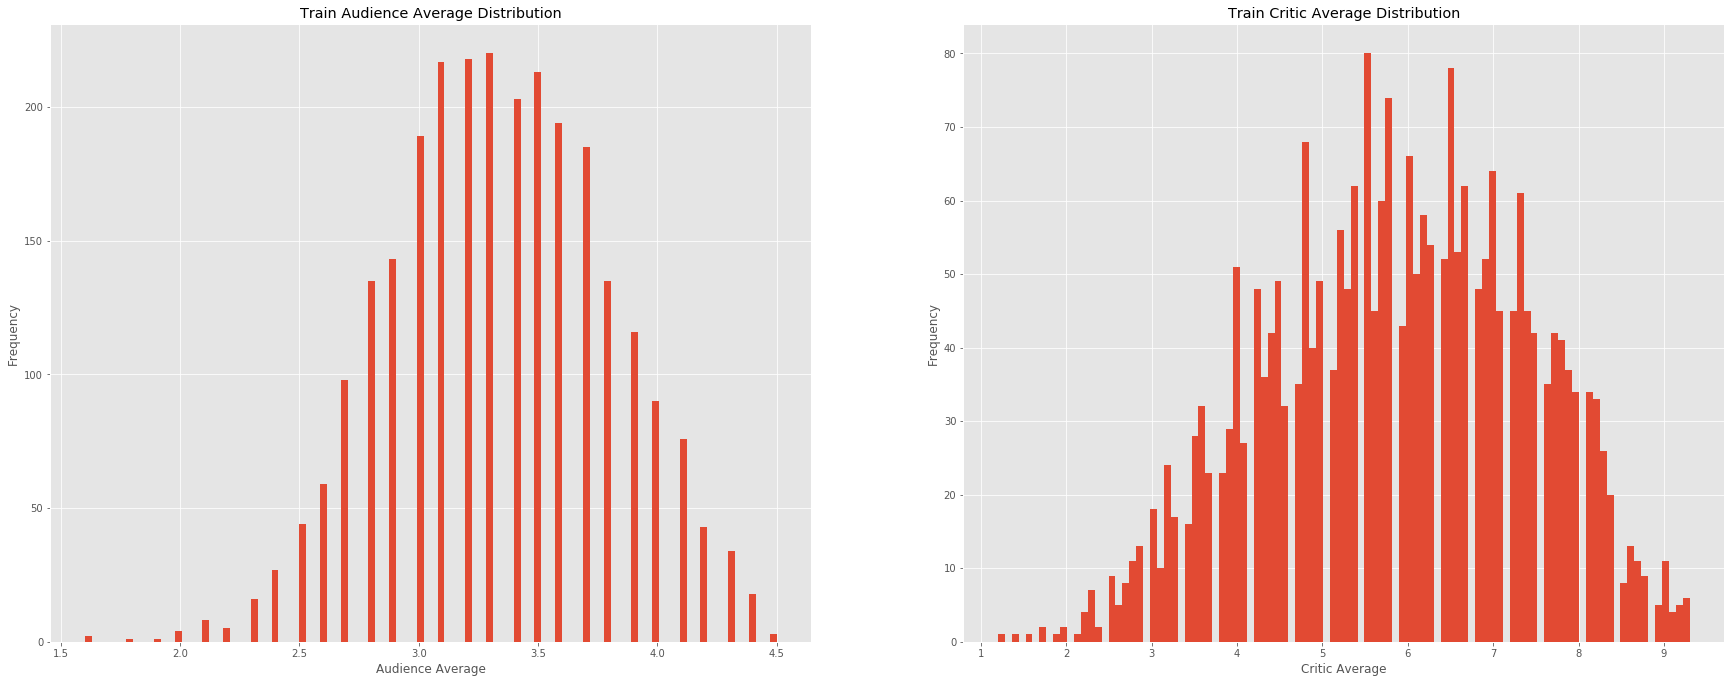

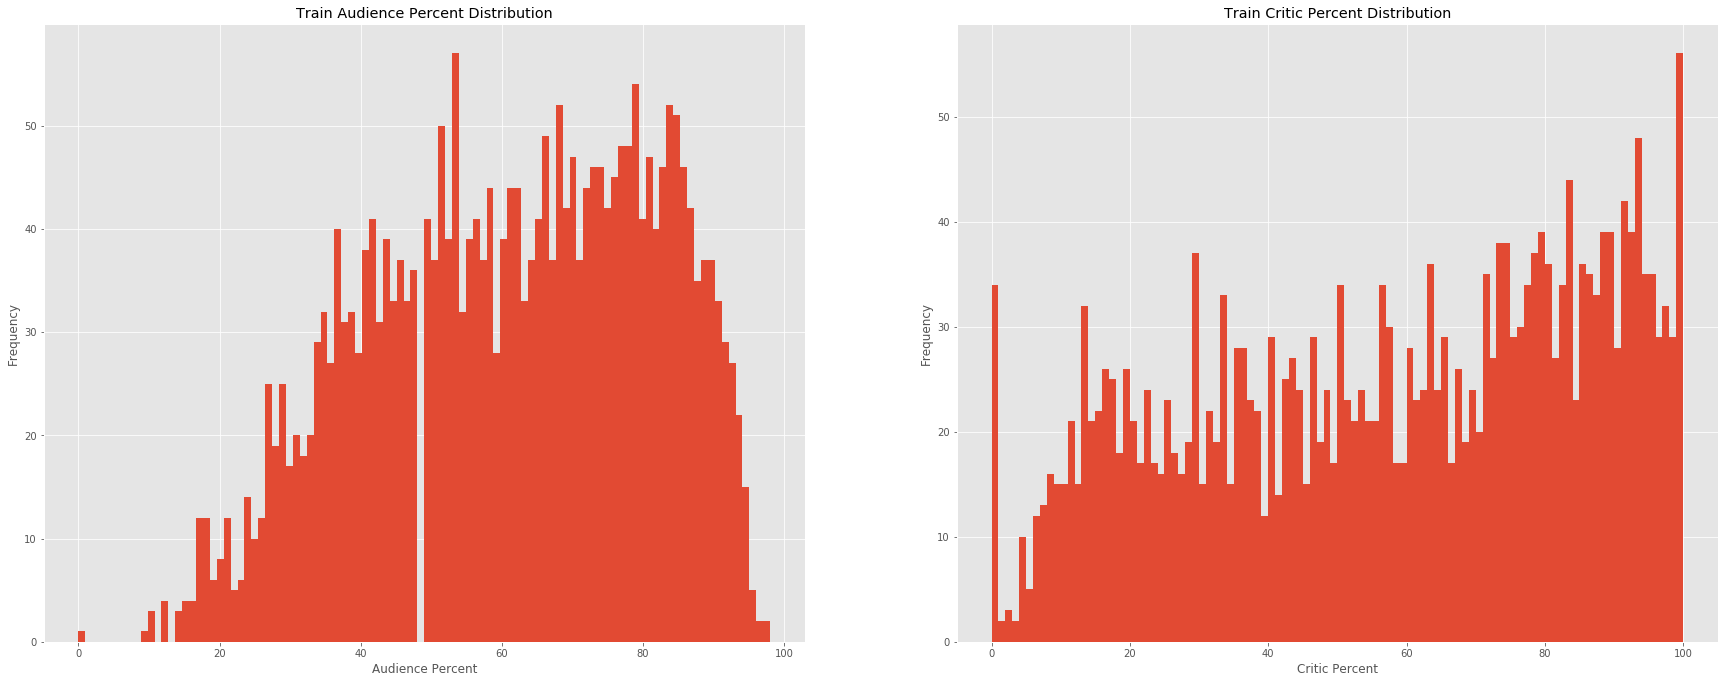

In [26]:
fig = plt.figure(figsize=(30, 25))

plt.subplot(221)
train['audience_average'].plot(kind='hist',bins=100)
plt.title('Train Audience Average Distribution')
plt.xlabel('Audience Average')

plt.subplot(222)
train['critic_average'].plot(kind='hist',bins=100)
plt.title('Train Critic Average Distribution')
plt.xlabel('Critic Average')


plt.show()

fig = plt.figure(figsize=(30, 25))

plt.subplot(223)
train['audience_percent'].plot(kind='hist',bins=100)
plt.title('Train Audience Percent Distribution')
plt.xlabel('Audience Percent')

plt.subplot(224)
train['critic_percent'].plot(kind='hist',bins=100)
plt.title('Train Critic Percent Distribution')
plt.xlabel('Critic Percent')

plt.show()

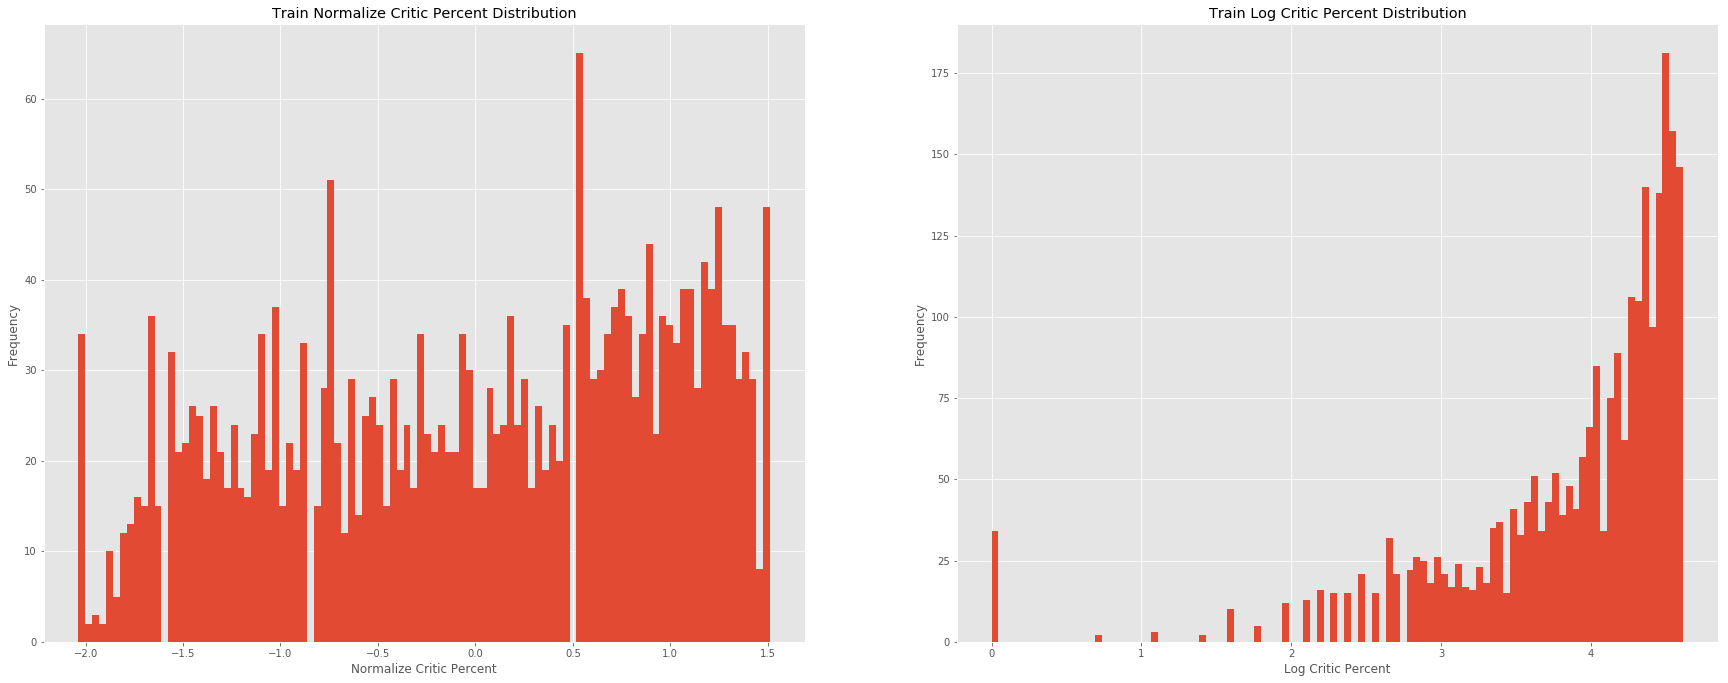

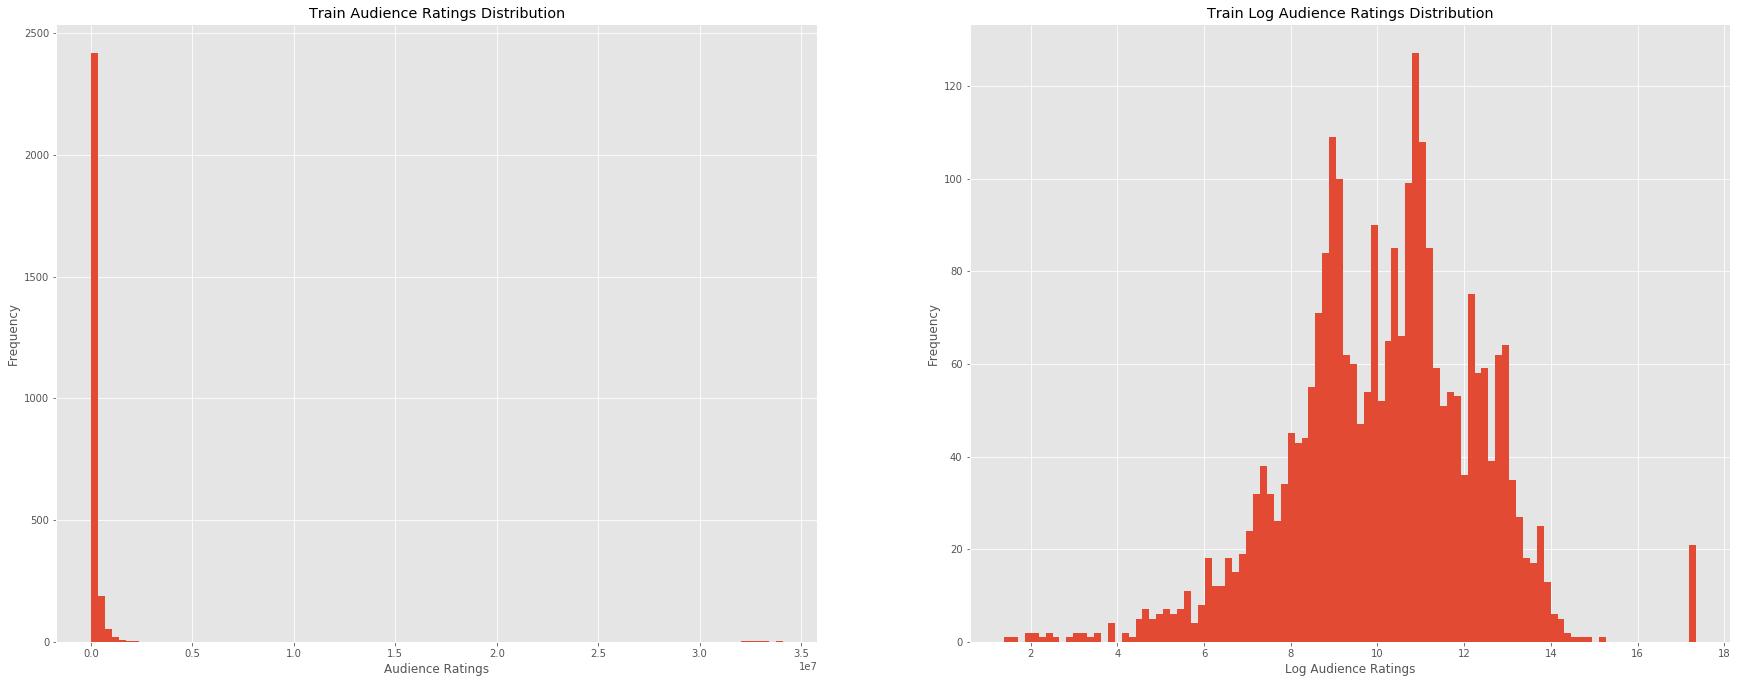

In [27]:
critic_value = train['critic_percent'].describe()
critic_test = (train['critic_percent'] - critic_value[1])/critic_value[2]

fig = plt.figure(figsize=(30, 25))

plt.subplot(221)
critic_test.plot(kind='hist',bins=100)
plt.title('Train Normalize Critic Percent Distribution')
plt.xlabel('Normalize Critic Percent')

plt.subplot(222)
np.log1p(train['critic_percent']).plot(kind='hist',bins=100)
plt.title('Train Log Critic Percent Distribution')
plt.xlabel('Log Critic Percent')

plt.show()


fig = plt.figure(figsize=(30, 25))

plt.subplot(223)
train['audience_ratings'].plot(kind='hist',bins=100)
plt.title('Train Audience Ratings Distribution')
plt.xlabel('Audience Ratings')

plt.subplot(224)
np.log1p(train['audience_ratings']).plot(kind='hist',bins=100)
plt.title('Train Log Audience Ratings Distribution')
plt.xlabel('Log Audience Ratings')

plt.show()

In [28]:
# Revising budget variable 

power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

In [29]:
# Putting log variables for skewed data 
train['log_budget']=np.log1p(train['budget'])
test['log_budget']=np.log1p(test['budget'])
train['log_popularity']=np.log1p(train['popularity'])
test['log_popularity']=np.log1p(test['popularity'])
train['log_audience_ratings'] = np.log1p(train['audience_ratings'])
test['log_audience_ratings'] = np.log1p(test['audience_ratings'])

In [30]:
def prepare(df):
    df['_budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']
    df['_year_to_log_budget'] = df['release_year'] / df['log_budget']
    df['_year_to_log_popularity'] = df['release_year'] / df['log_popularity']
    
    df['_percent_audience_to_critic_ratio'] = df['audience_percent']/df['critic_percent']
    df['_average_audience_to_critic_ratio'] = df['audience_average']/df['critic_average']
    df['_year_to_critic'] = df['release_year'] / df['critic_percent']
    df['_year_to_audience'] = df['release_year'] / df['audience_percent']
    df['_critic_p_to_critic_a_ratio'] = df['critic_percent']/df['critic_average']
    df['_audience_p_to_audience_a_ratio'] = df['audience_percent']/df['audience_average']
    df['_rutime_to_critic_ratio'] = df['runtime']/df['critic_percent']
    df['_rutime_to_audience_ratio'] = df['runtime']/df['audience_percent']
    df['_log_audience_rating_to_critic_ratio'] = df['log_audience_ratings']/df['critic_percent']
    df['_log_audience_rating_to_audience_ratio'] = df['log_audience_ratings']/df['audience_percent']
    
    

    df['has_homepage'] = 0
    df.loc[pd.isnull(df['homepage']) ,"has_homepage"] = 1
    
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 
    
    df['isTitleDifferent'] = 1
    df.loc[ df['original_title'] == df['title'] ,"isTitleDifferent"] = 0 

    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 

    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 
    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    df['meanruntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')
    df['meanPopularityByYear'] = df.groupby("release_year")["popularity"].aggregate('mean')
    df['meanBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('mean')
    df.fillna(value=0.0, inplace = True) 

    return df

train_new = prepare(train)
test_new = prepare(test)

### The revenue column in the test data was not given, so we want to try and predict the revenues. 

In [31]:
drop_columns=['homepage','imdb_id','poster_path','release_date','status','title', 'tagline', 'overview', 'original_title','all_genres','all_cast',
             'original_language','collection_name','all_crew']

train_new = train_new.drop(drop_columns,axis=1)
test_new = test_new.drop(drop_columns,axis=1)

In [32]:
# Formating for modeling

X = train_new.drop(['id', 'revenue'], axis=1)
y = np.log1p(train['revenue'])

X_test = test_new.drop(['id'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [33]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

lgb_model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
lgb_model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

eli5.show_weights(lgb_model, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[790]	training's rmse: 1.12305	valid_1's rmse: 1.81835


Weight,Feature
0.4181,audience_ratings
0.1328,_year_to_log_budget
0.0627,release_year
0.0347,_budget_year_ratio
0.0197,budget
0.0193,runtime
0.0184,log_audience_ratings
0.0159,_log_audience_rating_to_audience_ratio
0.0151,popularity
0.0147,critic_average


In [34]:
# already got the optimal hyperparamters so I just commented this out

# Random_Search_Params ={
#     "max_depth": [4,5,6],
#     "min_data_in_leaf": [15,20,25],
#     'learning_rate': [0.01,0.005],
#     'num_leaves': [25,30,35,40],
#     'boosting_type' : ['gbdt'],
#     'objective' : ['regression'],
#     'random_state' : [501]
#     }

# n_HP_points_to_test = 50

# random_search = RandomizedSearchCV(
#     estimator=lgb_model, param_distributions= Random_Search_Params, 
#     n_iter=n_HP_points_to_test,
#     cv=3,
#     refit=True,
#     random_state=314,
#     verbose=True)

# random_search.fit(X_train, y_train)
# print('Best score reached: {} with params: {} '.format(random_search.best_score_, random_search.best_params_))

# # Using parameters already set above, replace in the best from the random search

# params['learning_rate'] = random_search.best_params_['learning_rate']
# params['max_depth'] = random_search.best_params_['max_depth']
# params['num_leaves'] = random_search.best_params_['num_leaves']

In [35]:
opt_parameters = {'random_state': 501,
                 'objective': 'regression',
                 'num_leaves': 25,
                 'min_data_in_leaf': 15,
                 'max_depth': 6,
                 'learning_rate': 0.005,
                 'boosting_type': 'gbdt'} 

params['learning_rate'] = opt_parameters['learning_rate']
params['max_depth'] = opt_parameters['max_depth']
params['num_leaves'] = opt_parameters['num_leaves']
params['min_data_in_leaf'] = opt_parameters['min_data_in_leaf']

In [38]:
n_fold = 10 # usually a option for number of folds
random_seed=2222
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

# this function trains model for xgb and lgbm
# goes through multiple rounds and returns the best round to y_pred
# adds n_fold best y_pred to prediction and divide by n_folds
# oof is the returned array for the validation set
# also prints the feature importance for lgbm model
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=True, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=500, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=10000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=10000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    # prints a graph of each features' importance
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Fri Aug  2 21:21:33 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.41518	valid_1's rmse: 1.64742
[1000]	training's rmse: 1.175	valid_1's rmse: 1.61374
Early stopping, best iteration is:
[1126]	training's rmse: 1.13567	valid_1's rmse: 1.61244
Fold 1 started at Fri Aug  2 21:21:37 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.40638	valid_1's rmse: 1.89656
[1000]	training's rmse: 1.15761	valid_1's rmse: 1.81178
[1500]	training's rmse: 1.00065	valid_1's rmse: 1.8029
Early stopping, best iteration is:
[1598]	training's rmse: 0.976371	valid_1's rmse: 1.80075
Fold 2 started at Fri Aug  2 21:21:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.42113	valid_1's rmse: 1.64442
[1000]	training's rmse: 1.17914	valid_1's rmse: 1.59474
[1500]	training's rmse: 1.02285	valid_1's rmse: 1.57986
[2000]	training's rmse: 0.897847	valid_1's rmse: 1.57552


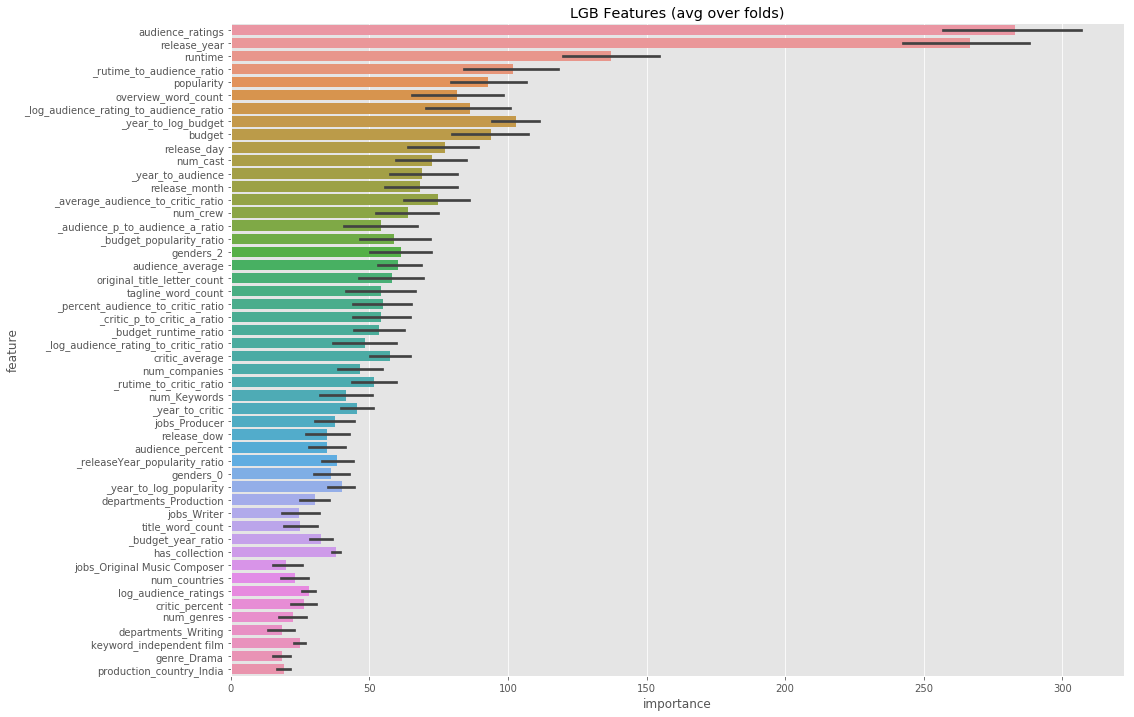

In [39]:
start = time.time()
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb')
end = time.time()

print("time elapsed:",end - start, "second")

In [40]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 6,
              'min_child_weight': 3,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}

start = time.time()
oof_xgb, prediction_xgb = train_model(X, X_test, y, params=xgb_params, model_type='xgb')
end = time.time()
print("time elapsed:",end - start, "second")

Fold 0 started at Fri Aug  2 21:30:28 2019
[0]	train-rmse:15.8211	valid_data-rmse:15.8957
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.00533	valid_data-rmse:1.59713
[1000]	train-rmse:0.677565	valid_data-rmse:1.57418
Stopping. Best iteration:
[1037]	train-rmse:0.660695	valid_data-rmse:1.5726

Fold 1 started at Fri Aug  2 21:30:48 2019
[0]	train-rmse:15.8428	valid_data-rmse:15.6953
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.990802	valid_data-rmse:1.77507
[1000]	train-rmse:0.655149	valid_data-rmse:1.75896
Stopping. Best iteration:
[1006]	train-rmse:0.652566	valid_data-rmse:1.75811

Fold 2 started at Fri Aug  2 21:31:08 2019
[0]	train-rmse:15.826	valid_data-rmse:15.8471
Multiple eval metrics have been passed: 'valid_data-rmse' will 

In [41]:
# predicted values for the test revenue
test['revenue'] = np.expm1((prediction_lgb + prediction_xgb)/ 2)

### Preparing data for predicting critic percent

In [42]:
train_critic = prepare(train)
test_critic = prepare(test)

In [43]:
drop_columns=['homepage','imdb_id','poster_path','release_date','status','title', 'tagline', 'overview', 'original_title','all_genres','all_cast',
             'original_language','collection_name','all_crew']

train_critic = train_critic.drop(drop_columns,axis=1)
test_critic = test_critic.drop(drop_columns,axis=1)

In [44]:
# Formating for modeling
X = train_critic.drop(['id', 'critic_percent'], axis=1)
y = train['critic_percent']

X_test = test_critic.drop(['id', 'critic_percent'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [45]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

lgb_model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
lgb_model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

eli5.show_weights(lgb_model, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.143903	valid_1's rmse: 0.256553
[2000]	training's rmse: 0.100291	valid_1's rmse: 0.253611
Early stopping, best iteration is:
[2737]	training's rmse: 0.0770084	valid_1's rmse: 0.252742


Weight,Feature
0.9154,_year_to_critic
0.0636,_critic_p_to_critic_a_ratio
0.0123,_rutime_to_critic_ratio
0.0065,critic_average
0.0013,_log_audience_rating_to_critic_ratio
0.0002,_year_to_audience
0.0002,_percent_audience_to_critic_ratio
0.0002,runtime
0.0001,release_year
0.0001,audience_ratings


In [46]:
opt_parameters = {'random_state': 501,
                  'objective': 'regression',
                  'num_leaves': 25,
                  'min_data_in_leaf': 15,
                  'max_depth': 5,
                  'learning_rate': 0.005,
                  'boosting_type': 'gbdt'} 

params['learning_rate'] = opt_parameters['learning_rate']
params['max_depth'] = opt_parameters['max_depth']
params['num_leaves'] = opt_parameters['num_leaves']
params['min_data_in_leaf'] = opt_parameters['min_data_in_leaf']

Fold 0 started at Fri Aug  2 21:34:39 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 2.61413	valid_1's rmse: 2.63751
[1000]	training's rmse: 0.306135	valid_1's rmse: 0.372654
[1500]	training's rmse: 0.167931	valid_1's rmse: 0.260123
[2000]	training's rmse: 0.147435	valid_1's rmse: 0.249578
[2500]	training's rmse: 0.135415	valid_1's rmse: 0.247428
[3000]	training's rmse: 0.123929	valid_1's rmse: 0.246753
[3500]	training's rmse: 0.113354	valid_1's rmse: 0.246218
[4000]	training's rmse: 0.104016	valid_1's rmse: 0.245828
[4500]	training's rmse: 0.0951258	valid_1's rmse: 0.245441
Early stopping, best iteration is:
[4661]	training's rmse: 0.0924725	valid_1's rmse: 0.245262
Fold 1 started at Fri Aug  2 21:34:50 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 2.62239	valid_1's rmse: 2.58071
[1000]	training's rmse: 0.30817	valid_1's rmse: 0.372866
[1500]	training's rmse: 0.169579	valid_1's rmse: 0.276945
[200

[8000]	training's rmse: 0.0503201	valid_1's rmse: 0.257156
[8500]	training's rmse: 0.0464304	valid_1's rmse: 0.257007
[9000]	training's rmse: 0.0428311	valid_1's rmse: 0.256884
[9500]	training's rmse: 0.0395952	valid_1's rmse: 0.256725
[10000]	training's rmse: 0.0366187	valid_1's rmse: 0.256566
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.0366187	valid_1's rmse: 0.256566
Fold 9 started at Fri Aug  2 21:37:04 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 2.62051	valid_1's rmse: 2.62157
[1000]	training's rmse: 0.305741	valid_1's rmse: 0.337209
[1500]	training's rmse: 0.166094	valid_1's rmse: 0.223976
[2000]	training's rmse: 0.145244	valid_1's rmse: 0.2173
[2500]	training's rmse: 0.133833	valid_1's rmse: 0.216666
[3000]	training's rmse: 0.123447	valid_1's rmse: 0.216247
[3500]	training's rmse: 0.113664	valid_1's rmse: 0.215523
[4000]	training's rmse: 0.104454	valid_1's rmse: 0.215192
[4500]	training's rmse: 0.09560

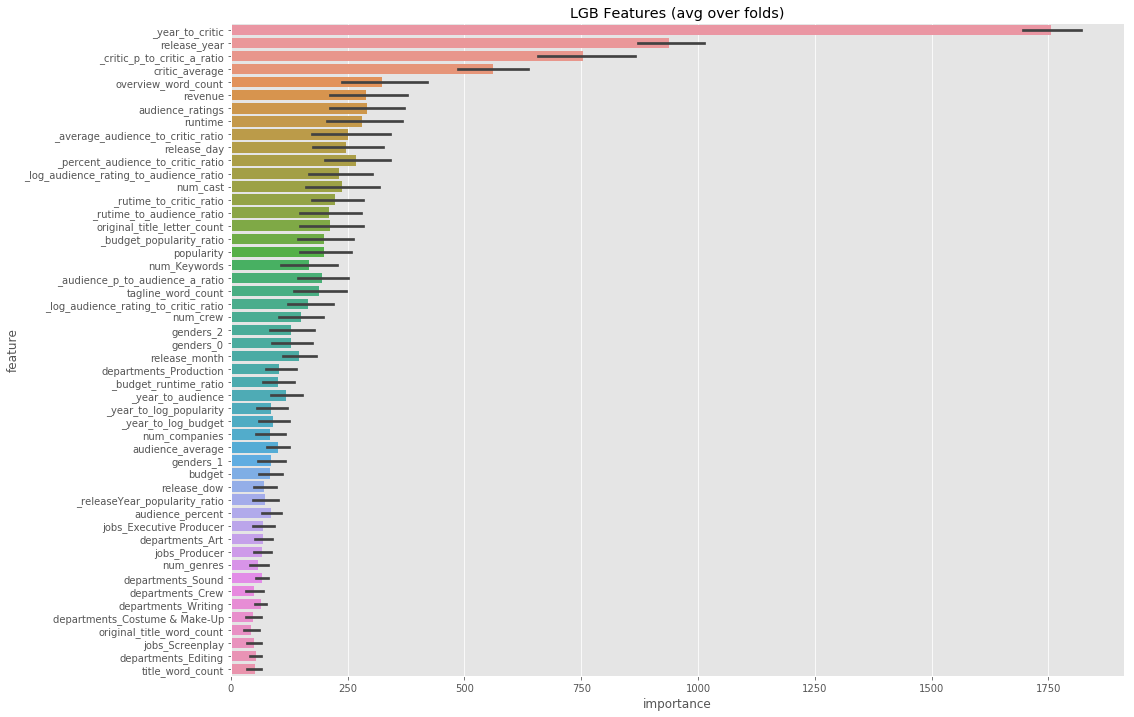

In [47]:
start = time.time()
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb')
end = time.time()

print("time elapsed:",end - start, "second")

In [48]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 6,
              'min_child_weight': 3,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}

start = time.time()
oof_xgb, prediction_xgb = train_model(X, X_test, y, params=xgb_params, model_type='xgb')
end = time.time()
print("time elapsed:",end - start, "second")

Fold 0 started at Fri Aug  2 21:37:15 2019
[0]	train-rmse:59.9445	valid_data-rmse:60.1828
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.471092	valid_data-rmse:0.502184
[1000]	train-rmse:0.089808	valid_data-rmse:0.236008
[1500]	train-rmse:0.061082	valid_data-rmse:0.23011
[2000]	train-rmse:0.042682	valid_data-rmse:0.22875
[2500]	train-rmse:0.030243	valid_data-rmse:0.228297
[3000]	train-rmse:0.021717	valid_data-rmse:0.227851
[3500]	train-rmse:0.015664	valid_data-rmse:0.227695
[4000]	train-rmse:0.011448	valid_data-rmse:0.227586
[4500]	train-rmse:0.008357	valid_data-rmse:0.227546
Stopping. Best iteration:
[4395]	train-rmse:0.008952	valid_data-rmse:0.227528

Fold 1 started at Fri Aug  2 21:38:29 2019
[0]	train-rmse:60.221	valid_data-rmse:57.6543
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-r

Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.476613	valid_data-rmse:0.540161
[1000]	train-rmse:0.091695	valid_data-rmse:0.237957
[1500]	train-rmse:0.061964	valid_data-rmse:0.231584
[2000]	train-rmse:0.043758	valid_data-rmse:0.229402
[2500]	train-rmse:0.031367	valid_data-rmse:0.228417
[3000]	train-rmse:0.022857	valid_data-rmse:0.227823
[3500]	train-rmse:0.016482	valid_data-rmse:0.227644
[4000]	train-rmse:0.012032	valid_data-rmse:0.227434
[4500]	train-rmse:0.008854	valid_data-rmse:0.22731
Stopping. Best iteration:
[4771]	train-rmse:0.007505	valid_data-rmse:0.227278

CV mean score: 0.2406, std: 0.0396.
time elapsed: 955.0017104148865 second


In [51]:
rms = np.sqrt(mean_squared_error(test['critic_percent'], prediction_lgb))

RMSE of Test dataset

In [52]:
rms

25.10305463005073